In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First run voxelize and ANN interpolation. The latter only with dense/small particles to save computational cost.

In [4]:
from vpower.interp import SimulationParticles
import vpower.voxelize
Nsize = 256
radii_threshold = 1.                             # np.min(allPar.h())
# 1 for all voxelize, 0 for no voxelize

SNAPSHOT = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind0_gmc9/snapshot_550.hdf5'
inputParticles = SimulationParticles.load_snapshot(SNAPSHOT, remove_bulk_velocity=False)

denseParticles = inputParticles[inputParticles.h() <= radii_threshold]
voxelizeField = denseParticles.voxelize_interp_to_field(Nsize=Nsize)

Interpolating velocity field...
Padding:  0.035411309549151726 Lbox:  1.0708226190983035 Nsize:  274
Auto padding done. Time elapsed: 1.67 s


OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 86407227 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	8.066e+07 exact calculations (R>Rmax),
	5.748e+06 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 86407227 numbers in 2652 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 12.8883 seconds
In the end, 0 in cpu_queue
/appalachia/d6/yujie/Test_PowerSpec/vpower/voxelize.py:108: RuntimeWarning: invalid value encountered in divide
  v_grid = vec_grid[..., :3] / vec_grid[..., 3, None]     # divide by mass


Interpolation done. Time elapsed: 18.61 s


In [5]:
annField = inputParticles.ann_interp_to_field(Nsize=Nsize, overwrite=True)

Interpolating velocity field...
Box length: 1.0, box size: 256
Data file saved. Time taken: 35.09 s
Query file saved. Time taken: 57.75 s



real	1m20.288s
user	1m18.571s
sys	0m1.388s


Approximate Nearest Neighbour complete. Time taken: 80.35 s.
ANN output read. Time taken: 7.58 s
Interpolation done. Time elapsed: 186.04 s


Before implement on actual data, let's run some tests to make sure we have a nice Numpy method for our job. According to test, something like 
```python
np.where(d <= 1/2*Lcell - R, voxelize, ANN)
```

Now read ANN output and make a `d` and `R` list for the boolean array.

In [6]:
import numpy as np
from vpower.interp import read_ann_to_grid
def read_ann_distance_to_grid(Nsize, file):
    ann_save = np.loadtxt(file, delimiter='\t')
    distance = np.array(ann_save[:, 2], dtype=np.float32)
    distance = distance.reshape(Nsize, Nsize, Nsize)
    return distance

d = read_ann_distance_to_grid(Nsize, 'ann_output.save')
R = read_ann_to_grid(inputParticles.h(), Nsize, 'ann_output.save')

In [13]:
# Numbers of cells uses voxelize
len(d[d - (1/2*annField.Lcell - R) < 0])

73690

Forefathers one and all, bear witness! Graft the two fields in one line.

In [48]:
# condition = (d >= (1/2*annField.Lcell - R))[..., None] | np.isnan(voxelizeField.get_data())
condition = (d >= (1/2*annField.Lcell - R))[..., None] | np.isnan(voxelizeField.get_data())
array = np.where(condition, annField, voxelizeField)

from vpower.interp import SimulationField3D
outputField = SimulationField3D(array[..., :3], array[..., 3], annField.Lcell)

Oops: maybe update the class for array operation? Note, `np.where` can only return arrays though.

In [49]:
import numpy as np
class Foo:
    def __init__(self, arr):
        self.arr = arr
        self.declare = "I'm a Foo!"

    def __getitem__(self, key):
        return Foo(self.arr[key])

    def __array__(self):
        return self.arr
    
    def __array_wrap__(self, out_arr):
        return Foo(out_arr)
    

a = np.random.rand(5)
foo = Foo(a)

b = np.random.rand(5)
print(foo[0:2].arr)
print((a - foo).arr)



[0.25106928 0.26091018]
[0. 0. 0. 0. 0.]


Make some plots and check the conservation!

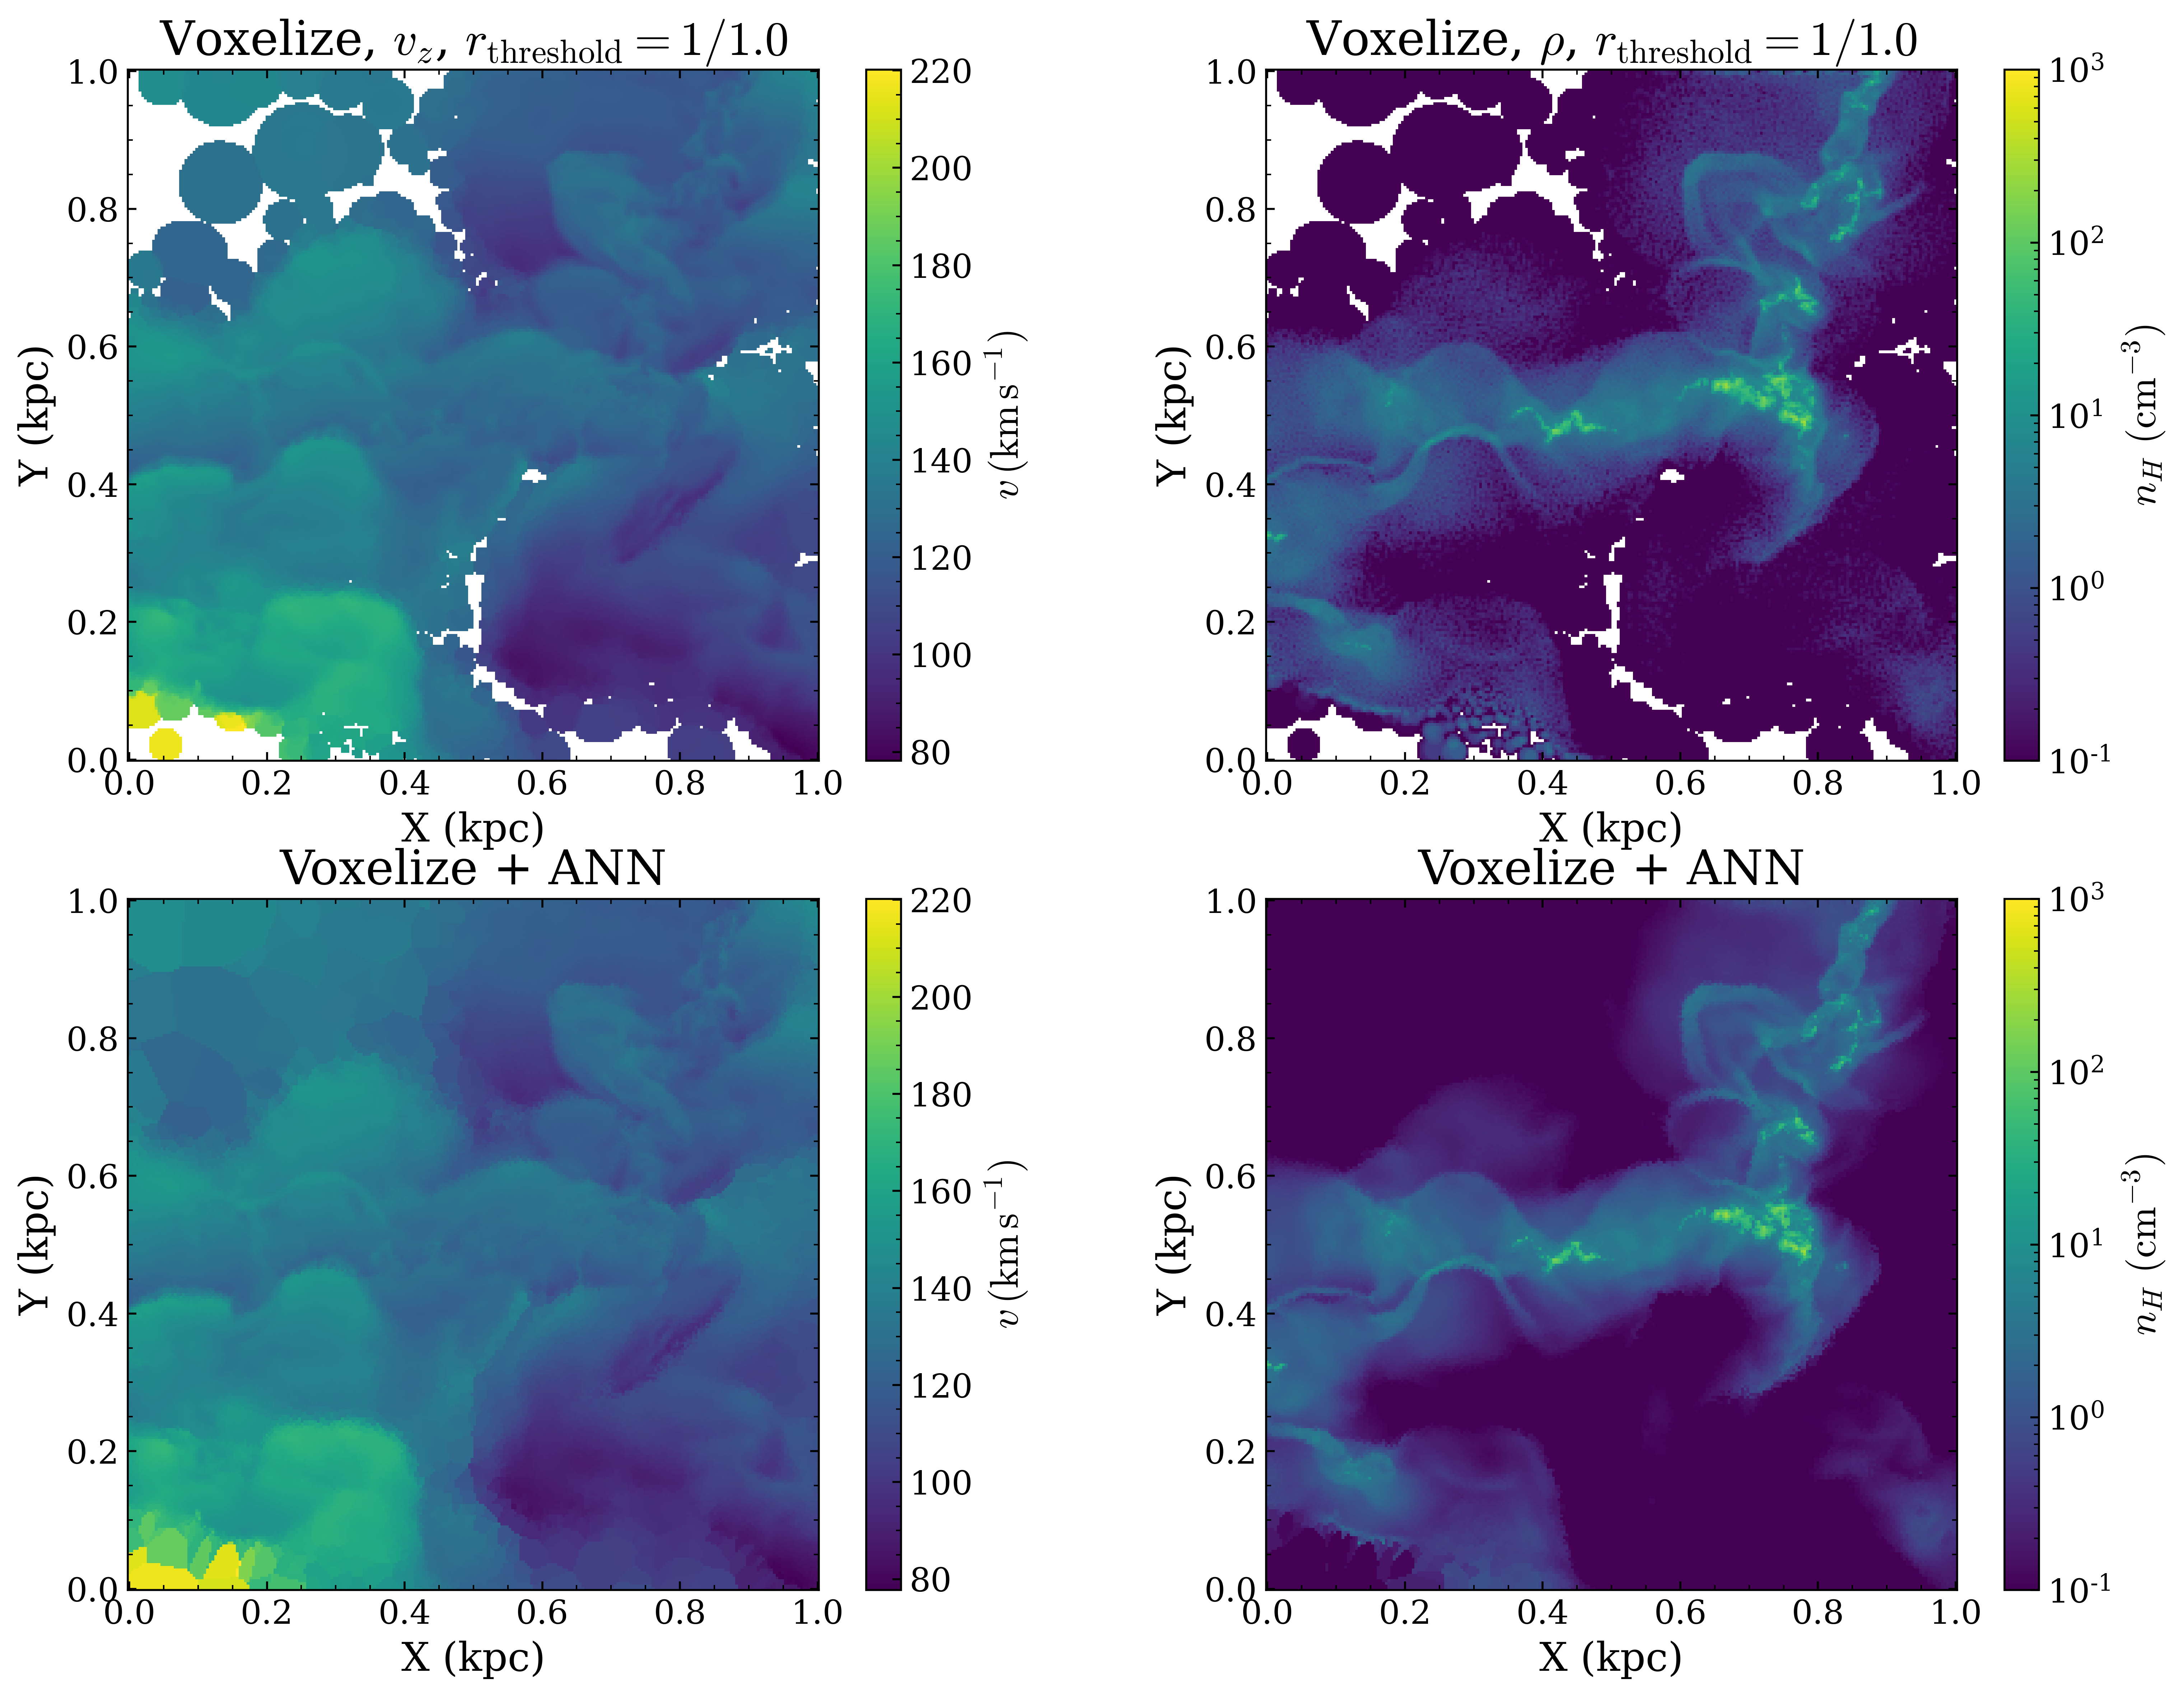

In [61]:
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')

fig, ax = plt.subplots(2, 2, figsize=(15, 11), dpi=500)

voxelizeField.plot_velocity_slice(component=0, index=voxelizeField.Nsize//2, axis=2, ax=ax[0,0])
ax[0,0].set_title("Voxelize, $v_z$, $r_\\mathrm{{threshold}}=1/{}$".format(1/radii_threshold))

outputField.plot_velocity_slice(component=0, index=outputField.Nsize//2, axis=2, ax=ax[1,0])
ax[1,0].set_title("Voxelize + ANN")

voxelizeField.plot_density_slice(index=voxelizeField.Nsize//2, axis=2, ax=ax[0,1])
ax[0,1].set_title("Voxelize, $\\rho$, $r_\\mathrm{{threshold}}=1/{}$".format(1/radii_threshold))

outputField.plot_density_slice(index=outputField.Nsize//2, axis=2, ax=ax[1,1])
ax[1,1].set_title("Voxelize + ANN")
plt.show()

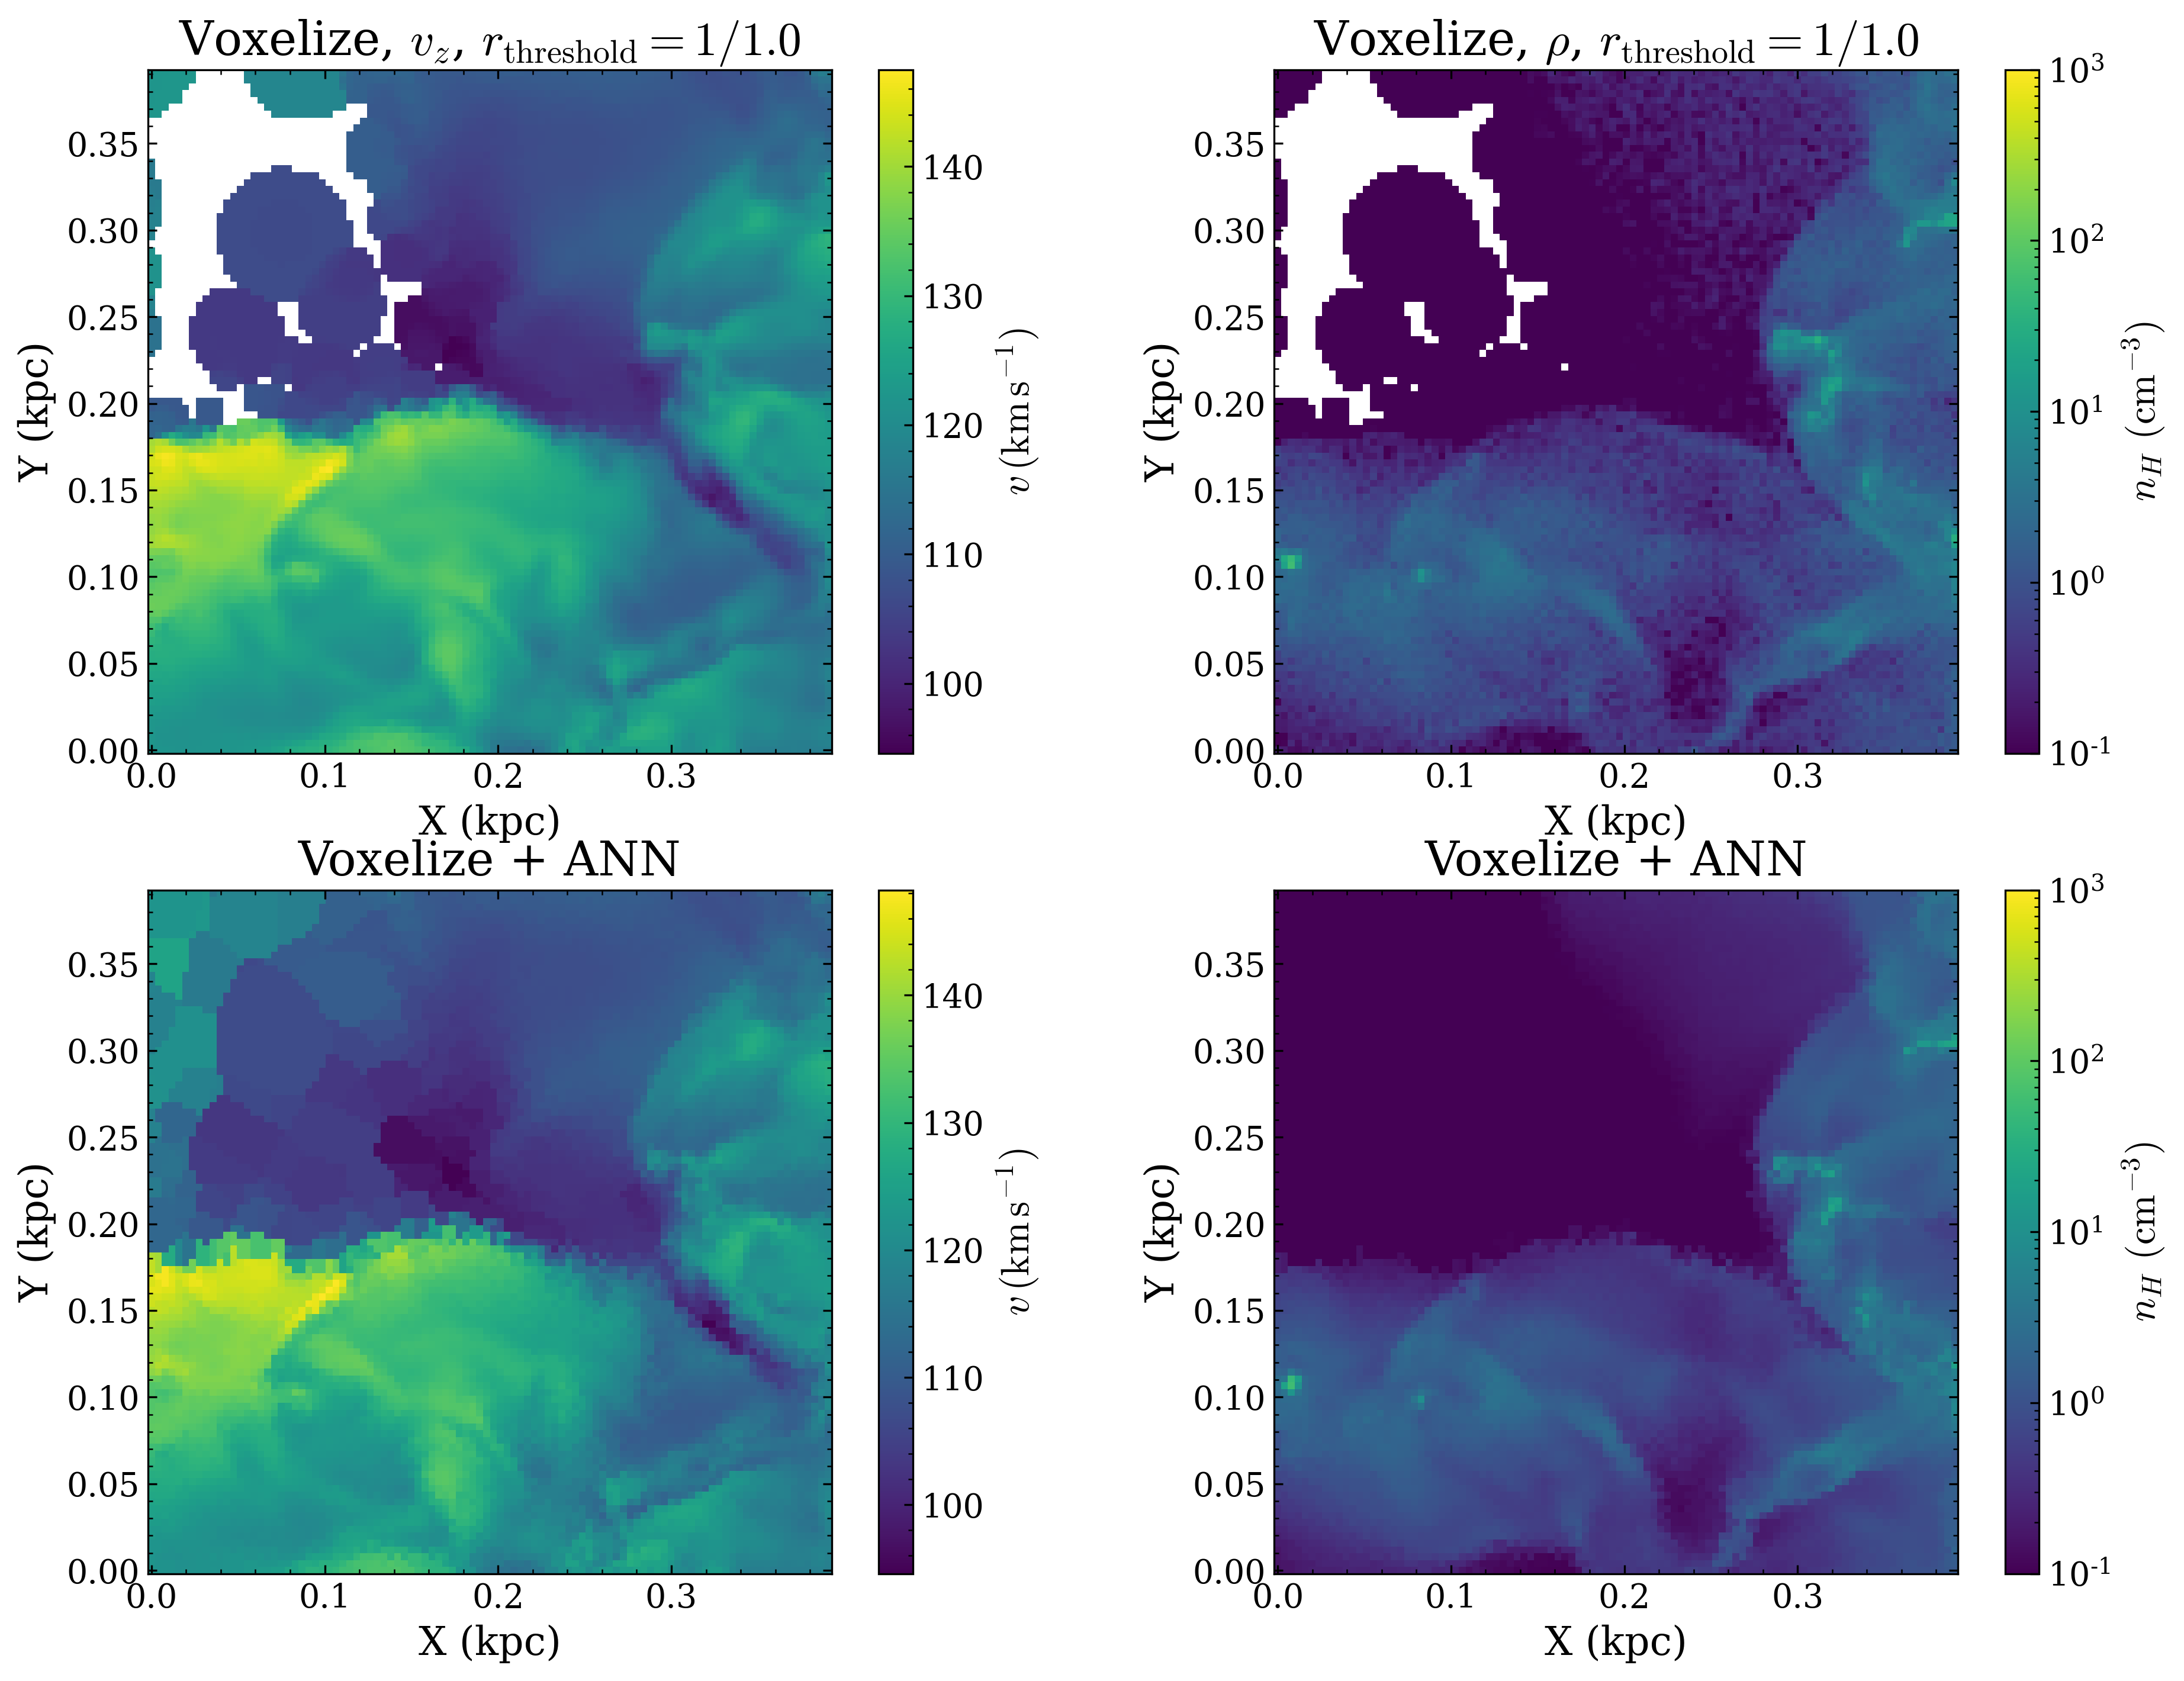

In [64]:
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')

fig, ax = plt.subplots(2, 2, figsize=(15, 11), dpi=300)

zoom_in_voxelizeField = voxelizeField[100:200,100:200,100:200]
zoom_in_outputField = outputField[100:200,100:200,100:200]

zoom_in_voxelizeField.plot_velocity_slice(component=0, index=zoom_in_voxelizeField.Nsize//2, axis=2, ax=ax[0,0])
ax[0,0].set_title("Voxelize, $v_z$, $r_\\mathrm{{threshold}}=1/{}$".format(1/radii_threshold))

zoom_in_outputField.plot_velocity_slice(component=0, index=zoom_in_outputField.Nsize//2, axis=2, ax=ax[1,0])
ax[1,0].set_title("Voxelize + ANN")

zoom_in_voxelizeField.plot_density_slice(index=zoom_in_voxelizeField.Nsize//2, axis=2, ax=ax[0,1])
ax[0,1].set_title("Voxelize, $\\rho$, $r_\\mathrm{{threshold}}=1/{}$".format(1/radii_threshold))

zoom_in_outputField.plot_density_slice(index=zoom_in_outputField.Nsize//2, axis=2, ax=ax[1,1])
ax[1,1].set_title("Voxelize + ANN")
plt.show()

In [51]:
from vpower.interp import check_conservation
check_conservation(inputParticles, outputField)

Total mass of particles: 1.260e-03
Total mass after interpolation: 1.201e-03
Total mass restored by 95.300%


Total momentum of particles: [ 0.16640169  0.2250191  -0.00676618]
Total momentum after interpolation: [ 0.15870159  0.21443691 -0.00649992]
Total momentum restored by (95.373%, 95.297%, 96.065%)


Total kinetic energy of particles: 3.141e+01
Total kinetic energy after interpolation: 2.995e+01
Total kinetic energy restored by 95.349%


| Resolution | Radii threshold | Mass restored | Momentum restored | Kinetic energy restored |
|------------|-----------------|---------------|-------------------|-------------------------|
| 256 | 1/512 | 96.685% | (96.686%, 96.672%, 97.168%) | 96.661% |
| 512 | 1/512 | 98.127% | (98.088%, 98.097%, 98.284%) | 98.050% |
| 1024 | 1/512 | 98.068% | (98.051%, 98.040%, 98.332%) | 98.011% |

Radii threshold = 1. (full voxelize), resolution = 256
For d > or < 1/2 Lcell - R, mass restored by 95.300%, momentum (95.373%, 95.297%, 96.065%), kinetic energy 95.349%.

For d > or < Lcell - R instead of 1/2 Lcell - R, mass restored by 98.924%, momentum (98.922%, 98.923%, 99.684%), kinetic energy 98.907%. 
For d > or < 1.5 Lcell - R, 99.626%, (99.679%, 99.634%, 100.351%), 99.663%.
For d > or < 2 Lcell - R, 99.860%, (99.906%, 99.871%, 100.359%), 99.898%.

For d > or < 1/2Lcell - 1/2 R, 97.782%, (97.769%, 97.776%, 98.674%), 97.753%.